# Identifying Entities in Healthcare Data

In [1]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Workspace set up: Import and Install useful packages.

In [3]:
!pip install pycrf
!pip install sklearn-crfsuite

  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=05655551d67ac3f8e82a13288afa0bfc051f57026593ad548d42c8f5b47ab235
  Stored in directory: /root/.cache/pip/wheels/0b/68/37/a457e156cfd6174ed28c9c8cb76f18eeb559b760d84c0a22eb
Successfully built pycrf
     |████████████████████████████████| 743 kB 5.9 MB/s 


In [4]:
import pandas as pd
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import numpy as np

spacy.require_gpu()
model = spacy.load("en_core_web_sm")

## Loading the data 

In [5]:
with open('/content/drive/MyDrive/NLP Assignment/train_sent', 'r') as file:
    train_S = file.read()
with open('/content/drive/MyDrive/NLP Assignment/train_label', 'r') as file:
    train_L = file.read()
with open('/content/drive/MyDrive/NLP Assignment/test_sent', 'r') as file:
    test_S = file.read()
with open('/content/drive/MyDrive/NLP Assignment/test_label', 'r') as file:
    test_L = file.read()

### Exploring the data

In [ ]:
print(train_S[:250])

All
live
births
>
or
=
23
weeks
at
the
University
of
Vermont
in
1995
(
n
=
2395
)
were
retrospectively
analyzed
for
delivery
route
,
indication
for
cesarean
,
gestational
age
,
parity
,
and
practice
group
(
to
reflect
risk
status
)

The
total
cesarea


In [ ]:
print(train_L[:250])

O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O

O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O

O
O
O
O
O
O
O
O
O
O
O
O
O
O
O

O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O




In [ ]:
print(test_S[:50])

Furthermore
,
when
all
deliveries
were
analyzed
,



In [ ]:
print(test_L[:50])

O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O
O



##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

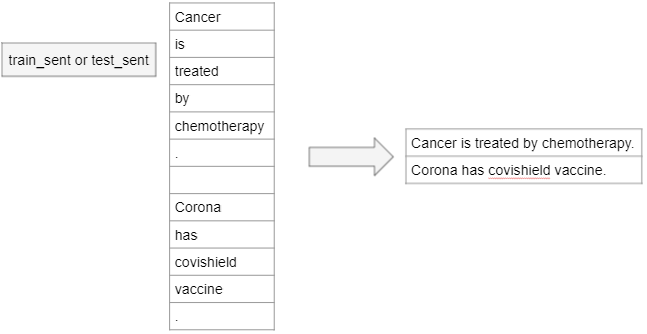

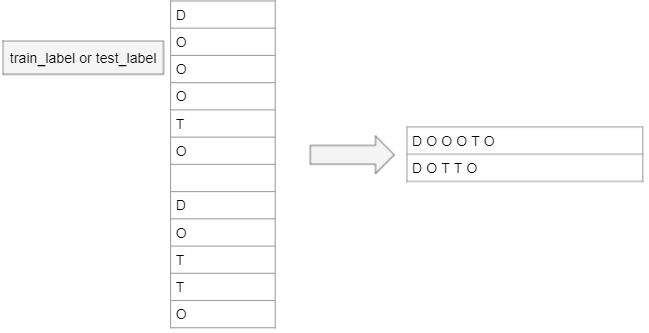

- The word_label_map has been defined to create a dataframe that shows one on one mapping of each word to its label. The dataframes created here have been used further. 

In [6]:
def word_label_map(df_sent,df_label):
  df_sent=df_sent.split('\n')
  df_label=df_label.split('\n')
  d=pd.DataFrame([df_sent,df_label]).T
  d.columns=['Word','Label']
  d['Word'] = np.where(d['Word']=='','End of Sentence',d['Word'])
  d['Label'] = np.where(d['Label']=='','End of Sentence',d['Label'])
  return d

In [7]:
#Applying function to train and test datasets
train_map = word_label_map(train_S,train_L)
test_map = word_label_map(test_S,test_L)

In [5]:
#Exploring mapped train data
train_map.head()

,Word,Label
0,All,O
1,live,O
2,births,O
3,>,O
4,or,O


In [6]:
#Exploring mapped test data
test_map.head()

,Word,Label
0,Furthermore,O
1,",",O
2,when,O
3,all,O
4,deliveries,O


- The function <b>preprocess_df</b> has been defined to make sentences or sequence of labels for each sentence in each dataset based on the empty line.

In [8]:
def preprocess_data(df):
  df=df.split('\n\n')
  df=[i.replace('\n',' ') for i in df]
  return df

In [9]:
#Applying preprocess_data function to all datasets to make sentences and sequences of labels
train_S=preprocess_data(train_S)
test_S=preprocess_data(test_S)
train_L=preprocess_data(train_L)
test_L=preprocess_data(test_L)

In [10]:
#Printing first five sentences and their labels
print(train_S[:5])
print(train_L[:5])

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O 

In [11]:
#Checking whether the final element is actually a sentence or not
print(train_S[-1])
print(train_L[-1])
print(test_S[-1])
print(test_L[-1])

- As seen above, the final element is not actually a sentence but just an empty and therefore has to be removed from the sentence and labels datasets for both train and test data.

In [12]:
#Last element of each dataset (list) is blank and is therefore removed
train_S = train_S[:len(train_S)-1]
train_L = train_L[:len(train_L)-1]
test_S = test_S[:len(test_S)-1]
test_L = test_L[:len(test_L)-1]

### Count the number of sentences in the processed train and test dataset 

In [167]:
print('Number of Sentences in the Processed Train dataset: '+str(len(train_S)))
print('Number of Sentences in the Processed Test dataset: '+str(len(test_S)))

Number of Sentences in the Processed Train dataset: 2599
Number of Sentences in the Processed Test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [168]:
print('Number of lines of labels in the Processed Train dataset: '+str(len(train_L)))
print('Number of lines of labels in the Processed Test dataset: '+str(len(test_L)))

Number of lines of labels in the Processed Train dataset: 2599
Number of lines of labels in the Processed Test dataset: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [15]:
#Argument "disable=['parser','ner']" has been used to reduce the time taken to obtain PoS tags as the dataset is quite large  
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

- The <b>tags</b> function has been defined to identify the PoS tag of a given word using Spacy.

In [16]:
def tags(word):
  tokens = nlp(word)
  for token in tokens:
    return token.pos_

In [17]:
#Appending the train and test datasets together to identify PoS tags for entire data
train_map['Data']='Train'
test_map['Data']='Test'
data_map=train_map.append(test_map,ignore_index=True)
data_map=data_map[data_map['Word']!='End of Sentence'].reset_index(drop=True)

In [18]:
data_map

,Word,Label,Data
0,All,O,Train
1,live,O,Train
2,births,O,Train
3,>,O,Train
4,or,O,Train
...,...,...,...
64515,globulin,T,Test
64516,for,O,Test
64517,recurrent,D,Test
64518,spontaneous,D,Test


In [19]:
#Applying tags function to appended dataset to get PoS tags for each word
data_map['PosTag']=data_map['Word'].apply(tags)

In [19]:
data_map

,Word,Label,Data,PosTag
0,All,O,Train,DET
1,live,O,Train,VERB
2,births,O,Train,NOUN
3,>,O,Train,X
4,or,O,Train,CCONJ
...,...,...,...,...
64515,globulin,T,Test,PROPN
64516,for,O,Test,ADP
64517,recurrent,D,Test,ADJ
64518,spontaneous,D,Test,ADJ


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [20]:
#Fetching most common noun words - to better define features for CRF
noun_freq = data_map.loc[data_map['PosTag'].isin(['NOUN','PROPN']),'Word'].value_counts() 
noun_freq_top_25 = list(noun_freq.head(25).index)
print(noun_freq.head(25))

patients        492
treatment       280
%               247
cancer          199
therapy         175
study           162
disease         137
lung            113
cell            103
clinical         95
group            89
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              77
cases            71
surgery          70
rate             67
risk             66
children         64
analysis         64
associated       63
survival         63
Name: Word, dtype: int64


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

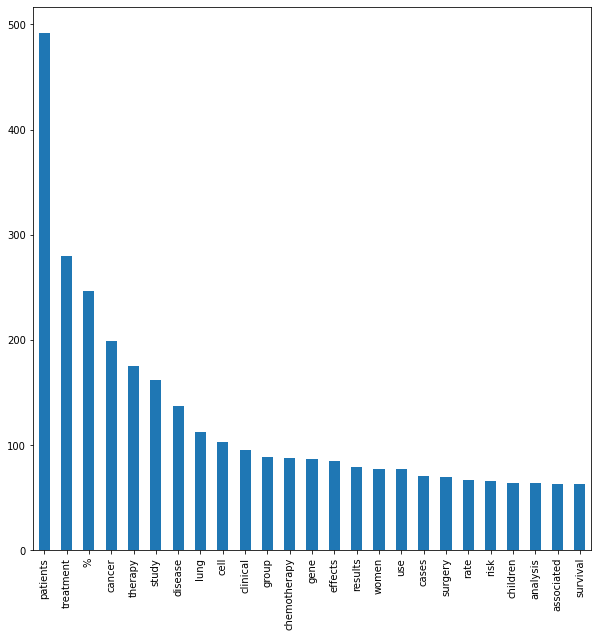

In [22]:
#Plotting frequency of most common nouns in entire dataset
plt.figure(figsize=(10,10))
noun_freq.head(25).plot.bar()
plt.show()

## Defining features for CRF





In [23]:
#Defining list of top words that have label T to use for feature definition
top_treat_words=data_map.loc[data_map['Label']=='T','Word'].value_counts()[:50]

In [24]:
#Removing words that are not related to treatments based on domain knowledge
rem=['(',')','and',',','with','of','the','or','a','in']
top_treat_words=top_treat_words.to_list()
top_treat_words=[top_treat_words.remove(i) for i in rem if i in top_treat_words]

In [25]:
#Defining list of top words that have label D to use for feature definition
top_dis_words=data_map.loc[data_map['Label']=='D','Word'].value_counts()[:50].to_list()

#Removing words that are not related to diseases based on domain knowledge
top_dis_words=[top_dis_words.remove(i) for i in rem if i in top_dis_words]

In [26]:
#Defining list of nouns for feature definition
nouns=data_map.loc[data_map['PosTag'].isin(['NOUN','PROPN']),'Word'].reset_index(drop=True).to_list()

In [27]:
#Checking if there are any sentences with less than two words as this affect how Features function is defined
ids=[]
for sentence in range(0,len(train_S)):
  if len(train_S[sentence])<2:
    ids.append(sentence)

In [169]:
print(len(ids))

9


- The <b>FeaturesWord</b> function has been defined to define the features to get the feature value for one word. 
- Features defined are:
1. Return decapitalised form of word (serves as identity function)
2. Return last 3 letters of word (Last 2 or 3 letters can indicate whether the word is the name of a drug/disease/treatment) 
3. Return last 2 letters of word
4. Return PoS tag of word
5. Check if word is a noun (treatments' and diseases' names are nouns)
6. Check if word is a number (Could be medication prescription indicating treatment)
7. Check if word starts with a capital letter (treatments' and diseases' names sometimes mentioned with capital first letter)
8. Check if word is in treatments list created earlier
9. Check if word is in diseases list created earlier
10. Check if word is the beginning word or the ending word of the sentence. 
11. Get same features for previous word in the sentence.
12. Get same features for next word in the sentence. <br>
Applying these features to the previous and next words for a given word can show the relation between these words, meaning, indicate that it is a phrase, etc., leading to a more extensive and accurate model. 

In [29]:

def FeaturesWord(sentence,idx,df=data_map):
  word = sentence[idx]
  features = [
    'word.lower=' + word.lower(),
    'word[-3:]=' + word[-3:],
    'word[-2:]=' + word[-2:],
    'word.posTag='+df.loc[df['Word']==word,'PosTag'].values[0],
    'word.isNoun=%s' % (word in nouns),
    'word.isdigit=%s' % word.isdigit(),
    'word.startsWithCapital=%s' % word[0].isupper(),
    'word.isInTreatmentsList=%s' % (word in top_treat_words),
    'word.IsInDiseaseList=%s' % (word in top_dis_words)
  ]
  if (idx==0)&(len(sentence)>1):
    features.append('BEG')
    next_word = sentence[idx+1]
    features.extend([
    'next_word.lower=' + next_word.lower(),
    'next_word[-3:]=' + next_word[-3:],
    'next_word[-2:]=' + next_word[-2:],
    'next_word.posTag='+df.loc[df['Word']==next_word,'PosTag'].values[0],
    'next_word.isNoun=%s' % (next_word in nouns),
    'next_word.isdigit=%s' % next_word.isdigit(),
    'next_word.startsWithCapital=%s' % next_word[0].isupper(),
    'next_word.isInTreatmentsList=%s' % (next_word in top_treat_words),
    'next_word.IsInDiseaseList=%s' % (next_word in top_dis_words)
    ])
  elif (idx==len(sentence)-1)&(len(sentence)>1):
    features.append('END')
    prev_word = sentence[idx-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word[-3:]=' + prev_word[-3:],
    'prev_word[-2:]=' + prev_word[-2:],
    'prev_word.posTag='+df.loc[df['Word']==prev_word,'PosTag'].values[0],
    'prev_word.isNoun=%s' % (prev_word in nouns),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.isInTreatmentsList=%s' % (prev_word in top_treat_words),
    'prev_word.IsInDiseaseList=%s' % (prev_word in top_dis_words)
    ])
  elif len(sentence)==1:
    features.append('BEG')
    features.append('END')
  else:
    next_word = sentence[idx+1]
    prev_word = sentence[idx-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word[-3:]=' + prev_word[-3:],
    'prev_word[-2:]=' + prev_word[-2:],
    'prev_word.posTag='+df.loc[df['Word']==prev_word,'PosTag'].values[0],
    'prev_word.isNoun=%s' % (prev_word in nouns),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.isInTreatmentsList=%s' % (prev_word in top_treat_words),
    'prev_word.IsInDiseaseList=%s' % (prev_word in top_dis_words)
    ])
    features.extend([
    'next_word.lower=' + next_word.lower(),
    'next_word[-3:]=' + next_word[-3:],
    'next_word[-2:]=' + next_word[-2:],
    'next_word.posTag='+df.loc[df['Word']==next_word,'PosTag'].values[0],
    'next_word.isNoun=%s' % (next_word in nouns),
    'next_word.isdigit=%s' % next_word.isdigit(),
    'next_word.startsWithCapital=%s' % next_word[0].isupper(),
    'next_word.isInTreatmentsList=%s' % (next_word in top_treat_words),
    'next_word.IsInDiseaseList=%s' % (next_word in top_dis_words)
    ])
  return features

Testing the function on a few words of a randomly chosen sentence

In [30]:
s=train_S[20]
s=s.split(' ')
#Beginning word
FeaturesWord(s,0)

['word.lower=down',
 'word[-3:]=own',
 'word[-2:]=wn',
 'word.posTag=ADV',
 'word.isNoun=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.isInTreatmentsList=False',
 'word.IsInDiseaseList=False',
 'BEG',
 'next_word.lower=syndrome',
 'next_word[-3:]=ome',
 'next_word[-2:]=me',
 'next_word.posTag=NOUN',
 'next_word.isNoun=True',
 'next_word.isdigit=False',
 'next_word.startsWithCapital=False',
 'next_word.isInTreatmentsList=False',
 'next_word.IsInDiseaseList=False']

In [31]:
#Intermediary word
FeaturesWord(s,1)

['word.lower=syndrome',
 'word[-3:]=ome',
 'word[-2:]=me',
 'word.posTag=NOUN',
 'word.isNoun=True',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.isInTreatmentsList=False',
 'word.IsInDiseaseList=False',
 'prev_word.lower=down',
 'prev_word[-3:]=own',
 'prev_word[-2:]=wn',
 'prev_word.posTag=ADV',
 'prev_word.isNoun=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=True',
 'prev_word.isInTreatmentsList=False',
 'prev_word.IsInDiseaseList=False',
 'next_word.lower=(',
 'next_word[-3:]=(',
 'next_word[-2:]=(',
 'next_word.posTag=PUNCT',
 'next_word.isNoun=False',
 'next_word.isdigit=False',
 'next_word.startsWithCapital=False',
 'next_word.isInTreatmentsList=False',
 'next_word.IsInDiseaseList=False']

In [32]:
#Ending word
FeaturesWord(s,len(s)-1)

['word.lower=diagnosed',
 'word[-3:]=sed',
 'word[-2:]=ed',
 'word.posTag=PROPN',
 'word.isNoun=True',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.isInTreatmentsList=False',
 'word.IsInDiseaseList=False',
 'END',
 'prev_word.lower=also',
 'prev_word[-3:]=lso',
 'prev_word[-2:]=so',
 'prev_word.posTag=ADV',
 'prev_word.isNoun=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.isInTreatmentsList=False',
 'prev_word.IsInDiseaseList=False']

## Getting the features

### Write a code/function to get the features for a sentence

The <b>FeaturesSentences</b> function has been defined to get the features of all the words in a given sentence.

In [33]:
def FeaturesSentences(sentence):
  sentence_list = sentence.split()
  return [FeaturesWord(sentence_list, pos) for pos in range(len(sentence_list))]

Testing the function on a randonly chosen sentence

In [34]:
s=train_S[20]
FeaturesSentences(s)

[['word.lower=down',
  'word[-3:]=own',
  'word[-2:]=wn',
  'word.posTag=ADV',
  'word.isNoun=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'BEG',
  'next_word.lower=syndrome',
  'next_word[-3:]=ome',
  'next_word[-2:]=me',
  'next_word.posTag=NOUN',
  'next_word.isNoun=True',
  'next_word.isdigit=False',
  'next_word.startsWithCapital=False',
  'next_word.isInTreatmentsList=False',
  'next_word.IsInDiseaseList=False'],
 ['word.lower=syndrome',
  'word[-3:]=ome',
  'word[-2:]=me',
  'word.posTag=NOUN',
  'word.isNoun=True',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'prev_word.lower=down',
  'prev_word[-3:]=own',
  'prev_word[-2:]=wn',
  'prev_word.posTag=ADV',
  'prev_word.isNoun=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.isInTreatmentsList=False',
  'prev_word.IsInDiseas

### Write a code/function to get the labels of a sentence

The <b>sentenceLabels</b> function has been defined to get the labels for a given sentence.

In [35]:
def sentenceLabels(labels):
  return labels.split()

Testing the function for a random sentence

In [36]:
sentenceLabels(train_L[20])

['D',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'D',
 'O',
 'O',
 'O']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [37]:
X_train = [FeaturesSentences(sentence) for sentence in train_S]
X_test = [FeaturesSentences(sentence) for sentence in test_S]

Checking that sentences are processed for a random sentence in train and test datasets

In [38]:
X_train[20]

[['word.lower=down',
  'word[-3:]=own',
  'word[-2:]=wn',
  'word.posTag=ADV',
  'word.isNoun=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'BEG',
  'next_word.lower=syndrome',
  'next_word[-3:]=ome',
  'next_word[-2:]=me',
  'next_word.posTag=NOUN',
  'next_word.isNoun=True',
  'next_word.isdigit=False',
  'next_word.startsWithCapital=False',
  'next_word.isInTreatmentsList=False',
  'next_word.IsInDiseaseList=False'],
 ['word.lower=syndrome',
  'word[-3:]=ome',
  'word[-2:]=me',
  'word.posTag=NOUN',
  'word.isNoun=True',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'prev_word.lower=down',
  'prev_word[-3:]=own',
  'prev_word[-2:]=wn',
  'prev_word.posTag=ADV',
  'prev_word.isNoun=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.isInTreatmentsList=False',
  'prev_word.IsInDiseas

In [170]:
X_test[20]

[['word.lower=sequelae',
  'word[-3:]=lae',
  'word[-2:]=ae',
  'word.posTag=PROPN',
  'word.isNoun=True',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'BEG',
  'next_word.lower=include',
  'next_word[-3:]=ude',
  'next_word[-2:]=de',
  'next_word.posTag=VERB',
  'next_word.isNoun=False',
  'next_word.isdigit=False',
  'next_word.startsWithCapital=False',
  'next_word.isInTreatmentsList=False',
  'next_word.IsInDiseaseList=False'],
 ['word.lower=include',
  'word[-3:]=ude',
  'word[-2:]=de',
  'word.posTag=VERB',
  'word.isNoun=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.isInTreatmentsList=False',
  'word.IsInDiseaseList=False',
  'prev_word.lower=sequelae',
  'prev_word[-3:]=lae',
  'prev_word[-2:]=ae',
  'prev_word.posTag=PROPN',
  'prev_word.isNoun=True',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.isInTreatmentsList=False',
  'prev_word.

### Define the labels as the target variable for test and the train dataset

In [39]:
Y_train = [sentenceLabels(labels) for labels in train_L]
Y_test = [sentenceLabels(labels) for labels in test_L]

Checking that labels of sentences are processed for a random sentence in train and test datasets

In [40]:
Y_train[20]

['D',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'O',
 'O',
 'O',
 'O',
 'O',
 'D',
 'D',
 'O',
 'O',
 'O']

In [171]:
Y_test[20]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D']

## Build the CRF Model

In [41]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
  crf.fit(X_train, Y_train)
except AttributeError:
  pass

<i><b>Please Note</b> : In case of attribute error, the model will be able to make predictions anyway.</i>

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [106]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [177]:
print('The f1 score is: '+str(round(metrics.flat_f1_score(Y_test, Y_pred, average='weighted')*100,2))+'%')

The f1 score is: 91.34%


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

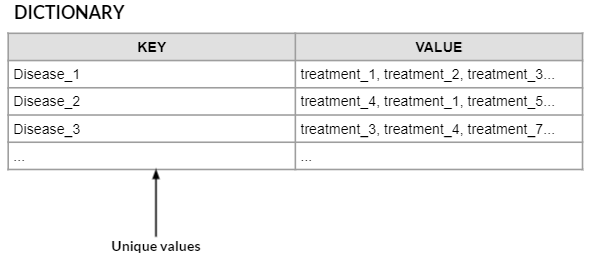

In [93]:
test_map

,Word,Label,Data
0,Furthermore,O,Test
1,",",O,Test
2,when,O,Test
3,all,O,Test
4,deliveries,O,Test
...,...,...,...
19670,recurrent,D,Test
19671,spontaneous,D,Test
19672,abortion,D,Test
19673,End of Sentence,End of Sentence,Test


In [110]:
#Adding predicted labels to test_map data for ease of comparison, checking accuracy and verifying results
yp=Y_pred.copy()
yp=[i+['End of Sentence'] for i in yp]

In [119]:
yp_df = yp[0] + yp[1]
for i in range(2,len(yp)):
  yp_df=yp_df+yp[i]

In [124]:
test_map=test_map.loc[:len(test_map)-2]
test_map['Pred_Label']=yp_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
test_map

,Word,Label,Data,Pred_Label
0,Furthermore,O,Test,O
1,",",O,Test,O
2,when,O,Test,O
3,all,O,Test,O
4,deliveries,O,Test,O
...,...,...,...,...
19669,for,O,Test,O
19670,recurrent,D,Test,O
19671,spontaneous,D,Test,O
19672,abortion,D,Test,O


In [179]:
print('The accuracy is: '+str(round((1-(len(test_map[test_map['Label']!=test_map['Pred_Label']])/len(test_map)))*100,2))+'%')

The accuracy is: 92.27%


In [140]:
#Defining diseases list to define disease_treatment dictionary
dis=[[] for i in range(0,len(X_test))]
for j in range(0,len(X_test)):
  try:
    dis[j]=' '.join([X_test[j][i][0][11:] for i in range(0,len(X_test[j])) if Y_pred[j][i]=='D'])
  except IndexError:
    print(j)

In [142]:
#Defining treatments list to define disease_treatment dictionary
treat=[[] for i in range(0,len(X_test))]
for j in range(0,len(X_test)):
  try:
    treat[j]=[X_test[j][i][0][11:] for i in range(0,len(X_test[j])) if Y_pred[j][i]=='T']
  except IndexError:
    print(j)

In [143]:
#Asserting lists are of same length - to accurately idenity treatment of a disease from the same sentence
assert len(dis)==len(treat)

In [161]:
#Defining disease-treatment dictionary
dis=[str(i) if dis[i]=='' else dis[i] for i in range(0,len(dis))]
disease_treatment={}
for i in range(0,len(dis)):
  try:
    disease_treatment[dis[i]]=treat[i]
  except IndexError:
    print(i)

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [163]:
disease_treatment['hereditary retinoblastoma']

['radiotherapy']

In [181]:
print('Treatment for the disease Hereditary Retinoblastoma: '+str(disease_treatment['hereditary retinoblastoma'][0].title()))

Treatment for the disease Hereditary Retinoblastoma: Radiotherapy


Confirming dictionary result using test_map dataset:

In [130]:
test_map[test_map['Word']=='hereditary']

,Word,Label,Data,Pred_Label
973,hereditary,O,Test,D
1184,hereditary,O,Test,D


In [131]:
test_map[test_map['Word']=='retinoblastoma']

,Word,Label,Data,Pred_Label
1185,retinoblastoma,O,Test,D


In [159]:
test_map.loc[1185:1200]

,Word,Label,Data,Pred_Label
1185,retinoblastoma,O,Test,D
1186,",",O,Test,O
1187,which,O,Test,O
1188,is,O,Test,O
1189,enhanced,O,Test,O
1190,by,O,Test,O
1191,radiotherapy,O,Test,T
1192,End of Sentence,End of Sentence,Test,End of Sentence
1193,A,O,Test,O
1194,radiation,O,Test,O


As seen above, the treatment mentioned in the same sentence as the disease <b>Hereditary Retinoblastoma</b> is <b>Radiotherapy</b>.

### Conclusion
Thus, the CRF model built using the features defined achieved an <b>F1 score of 91.34%</b> and an accuracy of 92%, and was able to <b>accuractely predict the treatment, Radiotherapy, for the given disease Hereditary Retinoblastoma.</b>